<center> 

### Customer Churn Preprocessing, Feature Engineering, and Modeling

</center>

In [1]:
# Installing dependencies via requirements.txt 
#%pip install -r ../requirements.txt 


In [22]:
# Importing libraries 
import warnings 
warnings.filterwarnings('ignore') 

import sys 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path 

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV  
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer 
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    roc_curve, 
    precision_recall_curve, 
    classification_report, 
    confusion_matrix
)
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as ImbPipeline 

import joblib 

try: 
    import shap 
except Exception: 
    shap = None 

# Getting the project root 
project_root = Path().resolve().parent 
sys.path.append(str(project_root)) 

from src.feature_engineering import feature_engineering 
from src.utils import model_path, data_path, visuals_path 


In [3]:
# Setting random_state for reproducibility 
random_state = 42 
np.random.seed(random_state)


In [4]:
# Loading data 
cleaned_raw_data_path = data_path / "cleaned_raw_data.csv" 
data = pd.read_csv(cleaned_raw_data_path) 
print(data.info()) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Making copy of the data 
df = data.copy() 


In [6]:
# Dropping customerID column and mapping target column (Churn) 
df.drop(columns=['customerID'], inplace=True, errors='ignore')
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0}) 


In [7]:
# Applying feature engineering to data 
df = feature_engineering(df) 
# Checking features 
df[['tenure','MonthlyCharges','TotalCharges','AvgChargesPerMonth','fiber_internet','electronic_check','month_to_month','internet_services_count','tenure_group']].head() 


,tenure,MonthlyCharges,TotalCharges,AvgChargesPerMonth,fiber_internet,electronic_check,month_to_month,internet_services_count,tenure_group
0,1,29.85,29.85,29.849970,0,1,1,1,0-12
1,34,56.95,1889.50,55.573528,0,0,0,2,24-48
2,2,53.85,108.15,54.074973,0,0,1,2,0-12
3,45,42.30,1840.75,40.905555,0,0,0,3,24-48
4,2,70.70,151.65,75.824962,1,1,1,0,0-12


In [8]:
# Column lists for pipeline 
numeric_features = ['tenure','MonthlyCharges','TotalCharges','AvgChargesPerMonth','internet_services_count'] 
# Categorical features for one-hot encoding 
ohe_features = ['Contract','InternetService','PaymentMethod','tenure_group']  
# Binary columns (Will end up all mapping to binary -- 'No internet service' = 0) 
binary_features = ['Partner','Dependents','PhoneService','PaperlessBilling','MultipleLines','SeniorCitizen',
'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

# Mapping binary columns 
binary_mapping = {'Yes':1, 'No':0, 'No phone service':0, 'No internet service':0} 
for c in binary_features:
    if c in df.columns: 
        df[c] = df[c].map(binary_mapping).fillna(df[c]) 
# Mapping gender (also binary) 
if 'gender' in df.columns: 
    df['gender'] = df['gender'].map({'Male':0, 'Female':1}) 


# Keeping list of feature columns 
all_features = [c for c in df.columns if c != 'Churn'] 
print('Number of features: ', len(all_features)) 

Number of features:  25


In [9]:
# Building preprocessing pipeline 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features), 
    ('cat', categorical_transformer, ohe_features)
], remainder='drop')

print("Preprocessor created: Numeric features: ", numeric_features) 
print("OHE features: ", ohe_features) 




Preprocessor created: Numeric features:  ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth', 'internet_services_count']
OHE features:  ['Contract', 'InternetService', 'PaymentMethod', 'tenure_group']


In [10]:
# Splitting into train and test sets 
# Using strategied split since the classification is imbalanced 
x = df.drop(columns=['Churn']) 
y = df['Churn'] 


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state, stratify=y)
print("Train/test shapes: ", x_train.shape, x_test.shape) 
print("Train churn rate: ", y_train.mean(), 'Test churn rate: ', y_test.mean())


Train/test shapes:  (5634, 25) (1409, 25)
Train churn rate:  0.2653532126375577 Test churn rate:  0.2654364797728886


In [12]:
# Creating baseline models (Logistic Regression & Random Forest) -- Creating two pipelines 

# Logistic Regression pipeline (Using class_weight - not SMOTE) 
lr_pipeline = Pipeline(steps=[
    ('fe', FunctionTransformer(feature_engineering, validate=False)), 
    ('preproc', preprocessor), 
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state))
])

# Random Forest pipeline (Applying SMOTE to numeric feature matrix after preprocessing) 
rf_pipeline = ImbPipeline(steps=[
    ('fe', FunctionTransformer(feature_engineering, validate=False)), 
    ('preproc', preprocessor), 
    ('smote', SMOTE(random_state=random_state)), 
    ('clf', RandomForestClassifier(n_estimators=200, random_state=random_state))
])


In [13]:
# Fitting baseline models 
print("Fitting Logistic Regression baseline...") 
lr_pipeline.fit(x_train, y_train) 
print("Fitting Random Forest baseline...") 
rf_pipeline.fit(x_train, y_train) 


Fitting Logistic Regression baseline...
Fitting Random Forest baseline...


Pipeline(steps=[('fe',
                 FunctionTransformer(func=<function feature_engineering at 0x707fafe50900>)),
                ('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'AvgChargesPerMonth',
                                                   'internet_services_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Contract',
                                                   'InternetService',
                                                   'PaymentMethod',
                                                   'tenure_group'])])),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [14]:
# Evaluating baseline models 
models = {'LogisticRegression': lr_pipeline, 'RandomForest': rf_pipeline} 
results = {} 
for name, model in models.items(): 
    y_prob = model.predict_proba(x_test)[:,1]
    y_pred = (y_prob >= 0.5).astype(int) 
    roc = roc_auc_score(y_test, y_prob)
    pr = average_precision_score(y_test, y_prob) 
    classification_rep = classification_report(y_test, y_pred, output_dict=True) 
    results[name] = {'roc_auc': roc, 'pr_auc': pr, 'report': classification_rep} 
    print(f"--- {name} ---") 
    print('ROC AUC: ', roc) 
    print('PR AUC: ', pr) 
    print('Precision/Recall/F1 (avg macro): ', classification_rep['macro avg']) 

# Savings results summary 
results_df = pd.DataFrame({k: {'roc_auc': v['roc_auc'], 'pr_auc': v['pr_auc']} for k, v in results.items()}).T
results_df.to_csv(visuals_path / 'baseline_model_results.csv') 
print("\nSaved baseline results to Visuals/baseline_model_results.csv") 


--- LogisticRegression ---
ROC AUC:  0.8367718101733448
PR AUC:  0.6368602590434829
Precision/Recall/F1 (avg macro):  {'precision': 0.7018343329417343, 'recall': 0.75298509390581, 'f1-score': 0.7041012486178304, 'support': 1409.0}
--- RandomForest ---
ROC AUC:  0.8060877315353019
PR AUC:  0.5783955270726105
Precision/Recall/F1 (avg macro):  {'precision': 0.68750118465446, 'recall': 0.7044421194037562, 'f1-score': 0.6941625680162202, 'support': 1409.0}

Saved baseline results to Visuals/baseline_model_results.csv


In [15]:
# Hyperparameter tuning (RandomizedSearchCV) 
param_dist = {
    'clf__n_estimators': [100,200,400], 
    'clf__max_depth': [None, 6, 12], 
    'clf__min_samples_leaf': [1,2,4]
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state) 
rs = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist, n_iter=6, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=random_state)
print("Starting RandomizedSearchCV..") 
rs.fit(x_train, y_train) 
print('Best Score: ', rs.best_score_) 
print('Best Params: ', rs.best_params_) 
best_model = rs.best_estimator_ 

# Saving the best model (temporarily) 
joblib.dump(best_model, model_path / 'best_rf_pipeline.joblib') 
print("Saved best model to Models/best_rf_pipeline.joblib") 



Starting RandomizedSearchCV..
Best Score:  0.8421466829054194
Best Params:  {'clf__n_estimators': 400, 'clf__min_samples_leaf': 1, 'clf__max_depth': 6}
Saved best model to Models/best_rf_pipeline.joblib


In [16]:
# Final Evaluation --> Evaluating on the test set 
y_prob = best_model.predict_proba(x_test)[:,1] 
roc = roc_auc_score(y_test, y_prob) 
pr = average_precision_score(y_test, y_prob) 
print('Final model ROC AUC: ', roc) 
print('Final model PR AUC: ', pr) 


Final model ROC AUC:  0.840407915471854
Final model PR AUC:  0.6401131687900903


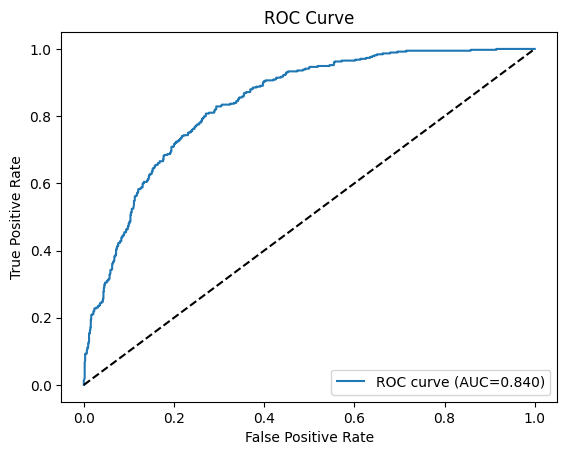

In [18]:
# ROC curve 
false_positive_rate, true_positive_rate, roc_threshold = roc_curve(y_test, y_prob) 
plt.figure() 
plt.plot(false_positive_rate, true_positive_rate, label=f'ROC curve (AUC={roc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig(visuals_path / 'roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()


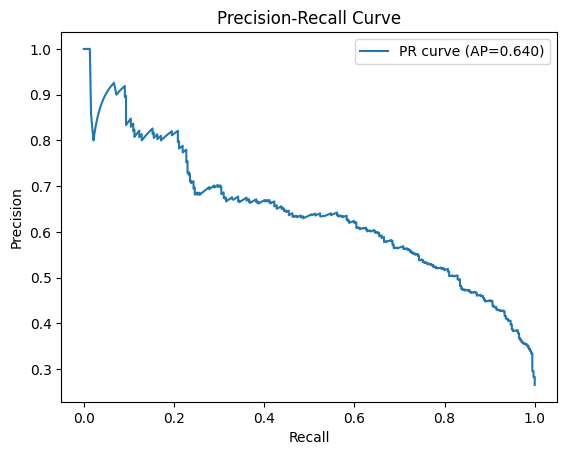

In [19]:
# Precision-Recall curve
precision, recall, pr_thresh = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AP={pr:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig(visuals_path / 'pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()


In [20]:
# Choosing threshold by max f1 score 
# Since using y_prob instead of just y_pred 
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
best_idx = np.nanargmax(f1_scores)
# Mapping best_idx to a threshold
if best_idx < len(pr_thresh):
    best_threshold = pr_thresh[best_idx]
else:
    best_threshold = 0.5
print('Best threshold (approximated by max F1):', best_threshold)


Best threshold (approximated by max F1): 0.5767711029237876


In [21]:
# Classification at best threshold
y_pred_thresh = (y_prob >= best_threshold).astype(int)
print('\nClassification report at best threshold:')
print(classification_report(y_test, y_pred_thresh))



Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.55      0.74      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



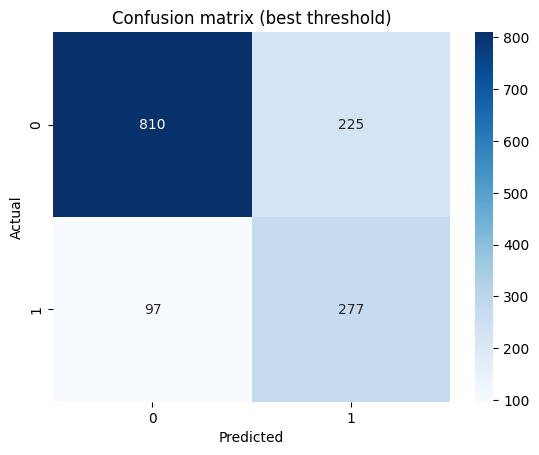

In [23]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresh)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix (best threshold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(visuals_path / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


In [24]:
# Getting feature names from ColumnTransformer 
def get_feature_names_from_cf(ct, input_features): 
    """
    Returns the output feature names from Column Transformer
    """
    feature_names = [] 
    for name, transformer, cols in ct.transformers_: 
        if name == 'remainder' and transformer == 'drop': 
            continue 
        if hasattr(transformer, 'named_steps'): 
            # Pipeline 
            last_step = list(transformer.named_steps.items())[-1][1] 
        else: 
            last_step = transformer 
        if isinstance(last_step, OneHotEncoder): 
            # Getting Categories 
            categories = last_step.get_feature_names_out(cols) 
            feature_names.extend(categories.tolist()) 
        else: 
            # Numeric Pipeline 
            feature_names.extend(cols) 
    return feature_names 


# Getting preprocessor from the pipeline 
preprocessor_in_pipeline = best_model.named_steps['preproc'] 
feature_names = get_feature_names_from_cf(preprocessor_in_pipeline, input_features=(numeric_features + ohe_features)) 
print("Number of features after preprocessing: ", len(feature_names)) 

# Creating transformed train data for SHAP (sample for speed) 
x_train_transformed = preprocessor_in_pipeline.transform(feature_engineering(x_train)) 

if shap is not None: 
    # SHAP for tree model 
    print("Calculating SHAP values (sampled)..") 
    # Extracting the tree model 
    tree_model = best_model.named_steps['clf'] 
    # Using a small sample 
    sample_idx = np.random.choice(x_train_transformed.shape[0], size=min(1000, x_train_transformed.shape[0]), replace=False) 
    x_sample = x_train_transformed[sample_idx] 
    explainer = shap.TreeExplainer(tree_model) 
    shap_values = explainer.shap_values(x_sample) 
    # Summary plot) 
    plt.figure() 
    shap.summary_plot(shap_values, x_sample, feature_names=feature_names, show=False) 
    plt.savefig(visuals_path / 'shap_summary.png', dpi=150, bbox_inches='tight') 
    plt.close() 
    print('Saved SHAP summary to Visuals/shap_summary.png') 
else: 
    print("SHAP not installed; skipping") 



Number of features after preprocessing:  20
Calculating SHAP values (sampled)..
Saved SHAP summary to Visuals/shap_summary.png


<Figure size 640x480 with 0 Axes>

In [26]:
# Saving final model  
final_model_path = model_path / 'churn_pipeline_best.joblib' 
joblib.dump(best_model, final_model_path) 
print('Saved final pipeline to --> ', final_model_path) 


Saved final pipeline to -->  /workspaces/Customer-Churn-Prediction/Models/churn_pipeline_best.joblib
